In [2]:
%pip install scikit-learn matplotlib pandas --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt

In [4]:
# load data
df = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/tracking_data/tracking_week_1.csv')
games = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/games.csv')
plays = pd.read_csv('https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com/raw/plays.csv')

In [5]:
# Function to calculate Euclidean distance
def calculate_distance(row, ball_position):
    return np.sqrt((ball_position['x'] - row['x'])**2 + (ball_position['y'] - row['y'])**2)

def create_feature_space(frame_df):
    # Extract gameId, playId, and frameId
    gameId = frame_df['gameId'].iloc[0]
    playId = frame_df['playId'].iloc[0]
    frameId = frame_df['frameId'].iloc[0]

    # Split into offense and defense
    offense = frame_df[frame_df['OFF'] == True].sort_values('distance_to_ball')
    defense = frame_df[frame_df['OFF'] == False].sort_values('distance_to_ball')

    # Initialize a dictionary to hold the features
    features = {'gameId': gameId, 'playId': playId, 'frameId': frameId}

    # Extract features for offense
    for i, player in enumerate(offense.itertuples(), start=1):
        features[f'OFF_PLAYER_{i}_X'] = player.x
        features[f'OFF_PLAYER_{i}_Y'] = player.y
        features[f'OFF_PLAYER_{i}_A'] = player.a
        features[f'OFF_PLAYER_{i}_S'] = player.s
        features[f'OFF_PLAYER_{i}_D'] = player.distance_to_ball

    # Extract features for defense
    for i, player in enumerate(defense.itertuples(), start=1):
        features[f'DEF_PLAYER_{i}_X'] = player.x
        features[f'DEF_PLAYER_{i}_Y'] = player.y
        features[f'DEF_PLAYER_{i}_A'] = player.a
        features[f'DEF_PLAYER_{i}_S'] = player.s
        features[f'DEF_PLAYER_{i}_D'] = player.distance_to_ball

    return features

def create_dataset(df, game_id):
    plays_filtered = plays.copy()[['gameId', 'playId', 'possessionTeam', 'defensiveTeam']]
    df = df.merge(plays_filtered, on=['gameId', 'playId'], how='left')
    df['OFF'] = df['possessionTeam'] == df['club']

    # filter for game id for training or testing
    df = df[df['gameId'] == game_id]

    # Initialize an empty list to store feature spaces for all frames
    all_feature_spaces = []

    # Iterate over each unique game and play
    for (gameId, playId), group in df.groupby(['gameId', 'playId']):
        # Filter rows for the ball carrier in this game and play
        ball_df = group[group['displayName'] == 'football']

        # Calculate distances for each frame in this game and play
        for frame in group['frameId'].unique():
            ball_position = ball_df[ball_df['frameId'] == frame].iloc[0]
            frame_df = group[group['frameId'] == frame]
            group.loc[group['frameId'] == frame, 'distance_to_ball'] = frame_df.apply(lambda row: calculate_distance(row, ball_position), axis=1)

        # Create feature space for each frame
        feature_space = [create_feature_space(group[group['frameId'] == frame]) for frame in group['frameId'].unique()]
        all_feature_spaces.extend(feature_space)

    # Convert to DataFrame
    feature_space_df = pd.DataFrame(all_feature_spaces)

    # setting the target var
    tackle_locations = df.loc[(df['displayName'] == 'football') & (df['event'] == 'tackle'), ['gameId', 'playId', 'frameId', 'x', 'y']].groupby(['gameId', 'playId'], as_index=False).first()
    tackle_locations = tackle_locations.rename({
        'x': 'x_tackle',
        'y': 'y_tackle'
    }, axis=1).drop('frameId', axis=1)

    final_df = feature_space_df.merge(tackle_locations, on=['gameId', 'playId'], how='left')

    final_df = final_df.loc[(final_df['x_tackle'].notna()) & (final_df['y_tackle'].notna())]
    features_list = final_df.columns[3:-2].tolist()
    return final_df, features_list

In [6]:
final_df, features_list = create_dataset(df, game_id=2022091101)
final_df.head()

,gameId,playId,frameId,OFF_PLAYER_1_X,OFF_PLAYER_1_Y,OFF_PLAYER_1_A,OFF_PLAYER_1_S,OFF_PLAYER_1_D,OFF_PLAYER_2_X,OFF_PLAYER_2_Y,...,DEF_PLAYER_11_A,DEF_PLAYER_11_S,DEF_PLAYER_11_D,DEF_PLAYER_12_X,DEF_PLAYER_12_Y,DEF_PLAYER_12_A,DEF_PLAYER_12_S,DEF_PLAYER_12_D,x_tackle,y_tackle
0,2022091101,85,1,27.40,30.37,3.05,2.03,3.260552,27.11,25.55,...,1.18,5.61,21.245470,41.52,11.59,3.29,3.39,23.490125,24.309999,38.23
1,2022091101,85,2,27.34,30.54,2.96,1.69,2.284842,26.81,25.46,...,3.54,3.05,21.173316,41.56,11.25,3.07,3.43,25.180569,24.309999,38.23
2,2022091101,85,3,27.28,30.70,2.43,1.54,2.590173,25.91,36.10,...,3.34,3.28,21.827535,41.56,10.90,2.77,3.45,26.887651,24.309999,38.23
3,2022091101,85,4,25.95,36.58,3.18,4.76,3.077288,27.24,30.83,...,3.53,3.58,22.242199,41.53,10.56,2.34,3.44,28.152238,24.309999,38.23
4,2022091101,85,5,25.95,37.03,3.71,4.35,1.957268,29.49,36.67,...,3.73,3.94,22.691506,41.48,10.24,2.23,3.30,29.589055,24.309999,38.23


In [7]:
print('Training data set shape: ', final_df.shape)
print('Number of features: ', len(features_list))

Training data set shape:  (3319, 120)
Number of features:  115


In [8]:
features_list[:5]

['OFF_PLAYER_1_X',
 'OFF_PLAYER_1_Y',
 'OFF_PLAYER_1_A',
 'OFF_PLAYER_1_S',
 'OFF_PLAYER_1_D']

In [9]:
X = final_df[features_list].values
y_x = final_df['x_tackle'].values.reshape(-1, 1)
y_y = final_df['y_tackle'].values.reshape(-1, 1)

print(X.shape, y_x.shape, y_y.shape)

(3319, 115) (3319, 1) (3319, 1)


In [10]:
# Initialize the Gaussian Process Regressor
kernel = RBF(length_scale=3.0, length_scale_bounds=(1e-2, 1e2))
gpr_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the model
gpr_x.fit(X, y_x)

GaussianProcessRegressor(kernel=RBF(length_scale=3), n_restarts_optimizer=10)

In [11]:
# Fit the model
gpr_y = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gpr_y.fit(X, y_y)

GaussianProcessRegressor(kernel=RBF(length_scale=3), n_restarts_optimizer=10)

In [12]:
test_df, features_list = create_dataset(df, 2022091106)
test_df.head()

,gameId,playId,frameId,OFF_PLAYER_1_X,OFF_PLAYER_1_Y,OFF_PLAYER_1_A,OFF_PLAYER_1_S,OFF_PLAYER_1_D,OFF_PLAYER_2_X,OFF_PLAYER_2_Y,...,DEF_PLAYER_11_A,DEF_PLAYER_11_S,DEF_PLAYER_11_D,DEF_PLAYER_12_X,DEF_PLAYER_12_Y,DEF_PLAYER_12_A,DEF_PLAYER_12_S,DEF_PLAYER_12_D,x_tackle,y_tackle
0,2022091106,59,1,45.33,6.40,2.12,6.30,2.668107,38.82,21.87,...,1.73,4.29,30.915255,45.88,48.70,2.75,3.53,40.913876,44.310001,0.1
1,2022091106,59,2,45.18,5.80,2.09,6.15,0.640312,38.87,21.42,...,0.79,2.99,32.771823,45.93,49.04,2.41,3.32,43.282325,44.310001,0.1
2,2022091106,59,3,45.02,5.20,1.82,6.08,0.510100,38.92,20.98,...,0.82,3.15,33.084456,45.98,49.36,2.18,3.10,44.194454,44.310001,0.1
3,2022091106,59,4,44.87,4.60,1.63,5.99,0.415934,38.96,20.57,...,0.97,3.33,33.429730,46.03,49.65,1.99,2.88,45.147306,44.310001,0.1
4,2022091106,59,5,44.73,4.02,1.48,5.92,0.331059,38.99,20.16,...,0.92,3.37,33.783916,46.07,49.92,2.01,2.64,46.069200,44.310001,0.1


In [13]:
test_df['y_tackle_pred'] = gpr_y.predict(test_df[features_list].values)
test_df['x_tackle_pred'] = gpr_x.predict(test_df[features_list].values)

test_df.head()

,gameId,playId,frameId,OFF_PLAYER_1_X,OFF_PLAYER_1_Y,OFF_PLAYER_1_A,OFF_PLAYER_1_S,OFF_PLAYER_1_D,OFF_PLAYER_2_X,OFF_PLAYER_2_Y,...,DEF_PLAYER_11_D,DEF_PLAYER_12_X,DEF_PLAYER_12_Y,DEF_PLAYER_12_A,DEF_PLAYER_12_S,DEF_PLAYER_12_D,x_tackle,y_tackle,y_tackle_pred,x_tackle_pred
0,2022091106,59,1,45.33,6.40,2.12,6.30,2.668107,38.82,21.87,...,30.915255,45.88,48.70,2.75,3.53,40.913876,44.310001,0.1,3.620764,42.170526
1,2022091106,59,2,45.18,5.80,2.09,6.15,0.640312,38.87,21.42,...,32.771823,45.93,49.04,2.41,3.32,43.282325,44.310001,0.1,3.895524,39.122159
2,2022091106,59,3,45.02,5.20,1.82,6.08,0.510100,38.92,20.98,...,33.084456,45.98,49.36,2.18,3.10,44.194454,44.310001,0.1,3.726692,38.581823
3,2022091106,59,4,44.87,4.60,1.63,5.99,0.415934,38.96,20.57,...,33.429730,46.03,49.65,1.99,2.88,45.147306,44.310001,0.1,3.547331,38.049387
4,2022091106,59,5,44.73,4.02,1.48,5.92,0.331059,38.99,20.16,...,33.783916,46.07,49.92,2.01,2.64,46.069200,44.310001,0.1,3.378050,37.577303


In [14]:
mean_absolute_error(test_df['y_tackle'], test_df['y_tackle_pred'])

10.321291724684645

In [15]:
mean_absolute_error(test_df['x_tackle'], test_df['x_tackle_pred'])

8.975432324822581

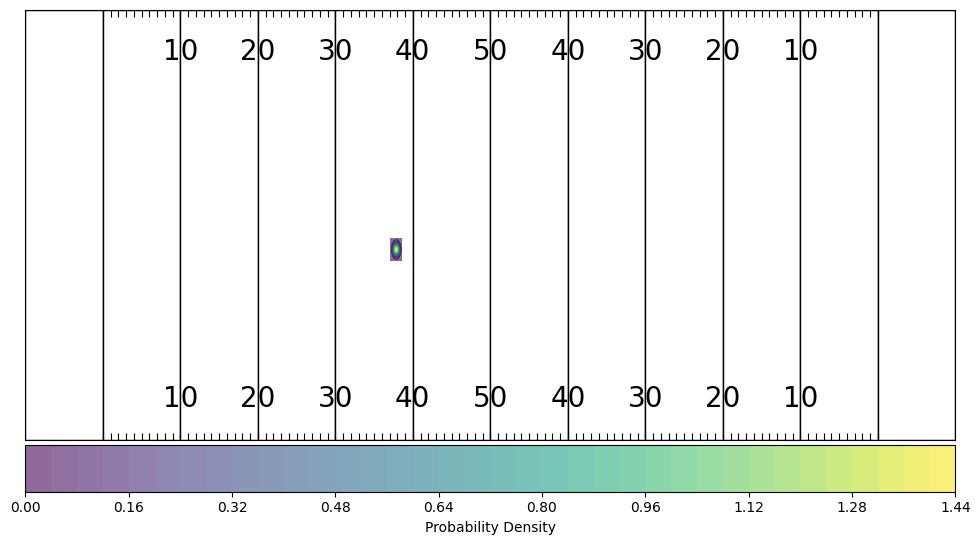

In [16]:
# take a sample play
sample_test_df = test_df.loc[test_df['playId'] == 83]
sample_frame_df = sample_test_df.loc[sample_test_df['frameId'] == 13][features_list]
sample_frame_df.head()

# Function to create a football field
def create_football_field(line_color='black', field_color='white'):
    fig, ax = plt.subplots(figsize=(12, 6.65))  # Set figure size to resemble a football field

    # Draw the field as a series of rectangles
    for i in range(12):
        rect = patches.Rectangle((10 * i, 0), 10, 53.3, linewidth=1, edgecolor=line_color, facecolor=field_color)
        ax.add_patch(rect)

    # Customize the ticks and labels
    ax.tick_params(axis='both', which='both', direction='in', pad=-40, length=5,
                   bottom=True, top=True, labeltop=True, labelbottom=True,
                   left=False, right=False, labelleft=False, labelright=False,
                   color=line_color)

    ax.set_xticks([i for i in range(10, 111)])
    label_set = []
    for i in range(1, 10):
        label_set += [" " for j in range(9)] + [str(i * 10) if i <= 5 else str((10 - i) * 10)]
    label_set = [" "] + label_set + [" " for j in range(10)]
    ax.set_xticklabels(label_set, fontsize=20, color=line_color)

    # Return the figure and axis objects
    return fig, ax

# Assume gpr_x and gpr_y are your trained GaussianProcessRegressor models for x and y
# Choose a single test sample (reshaped to 2D if necessary)
test_sample_x = sample_frame_df.values.reshape(1, -1)  # for gpr_x
test_sample_y = sample_frame_df.values.reshape(1, -1)  # for gpr_y

# Predict means and standard deviations for both x and y
mean_x, std_x = gpr_x.predict(test_sample_x, return_std=True)
mean_y, std_y = gpr_y.predict(test_sample_y, return_std=True)

# Create a 2D grid for plotting
x = np.linspace(mean_x - 3 * std_x, mean_x + 3 * std_x, 100)
y = np.linspace(mean_y - 3 * std_y, mean_y + 3 * std_y, 100)
X, Y = np.meshgrid(x, y)

# Calculate the joint PDF assuming independence between x and y
# Flatten X and Y for the positions to evaluate the PDF
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

# Create the covariance matrix assuming independence between x and y
covariance_matrix = np.diag([std_x[0]**2, std_y[0]**2])

# Create a multivariate normal distribution with the predicted means and covariance
rv = multivariate_normal([mean_x[0], mean_y[0]], covariance_matrix)

# Calculate the joint PDF
joint_pdf = rv.pdf(pos)

# Create the football field
fig, ax = create_football_field()

# Overlay the joint probability distribution onto the football field
contour = ax.contourf(X, Y, joint_pdf, levels=40, cmap='viridis', alpha=0.6)

# Add a colorbar to the plot
cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.01)
cbar.set_label('Probability Density', color='black')
cbar.ax.tick_params(colors='black')

# Set the plot limits to fit the football field dimensions
ax.set_xlim(0, 120)
ax.set_ylim(0, 53.3)

# Display the plot
plt.show()

In [39]:
# Group by gameId, playId, and frameId, and apply the MAE calculation
grouped = test_df.groupby(['gameId', 'playId', 'frameId'])
mae_x = grouped.apply(lambda g: mean_absolute_error(g['x_tackle'], g['x_tackle_pred']))
mae_y = grouped.apply(lambda g: mean_absolute_error(g['y_tackle'], g['y_tackle_pred']))

# Combine the results into a single DataFrame
mae_df = pd.DataFrame({'mae_x': mae_x, 'mae_y': mae_y}).reset_index()

In [40]:
mae_stats = mae_df.groupby('frameId').agg({'mae_x': ['mean', 'std'], 'mae_y': ['mean', 'std']})
mae_stats.columns = ['_'.join(col).strip() for col in mae_stats.columns.values]

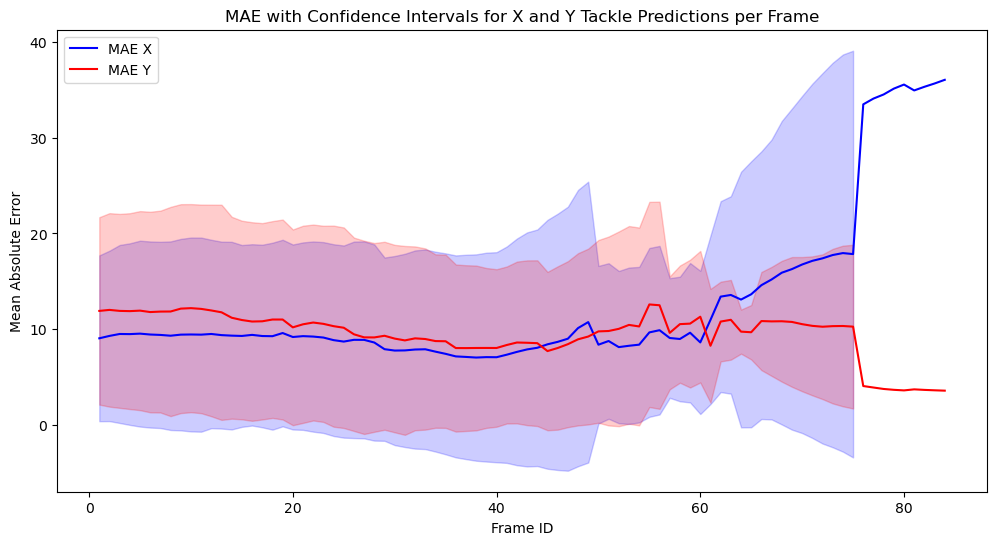

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(mae_stats.index, mae_stats['mae_x_mean'], label='MAE X', color='blue')
plt.fill_between(mae_stats.index, mae_stats['mae_x_mean'] - mae_stats['mae_x_std'], mae_stats['mae_x_mean'] + mae_stats['mae_x_std'], color='blue', alpha=0.2)
plt.plot(mae_stats.index, mae_stats['mae_y_mean'], label='MAE Y', color='red')
plt.fill_between(mae_stats.index, mae_stats['mae_y_mean'] - mae_stats['mae_y_std'], mae_stats['mae_y_mean'] + mae_stats['mae_y_std'], color='red', alpha=0.2)
plt.xlabel('Frame ID')
plt.ylabel('Mean Absolute Error')
plt.title('MAE with Confidence Intervals for X and Y Tackle Predictions per Frame')
plt.legend()
plt.show()